In [1]:
# Cell 1
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [22]:
# Cell 2 ──────────────────────────────────────────────────────────────
# same logic you used for the LSTM model, only the path is adapted
file_path = os.path.join("..", "data", "ts2024.csv")   # ← adjust if notebook is elsewhere
df = pd.read_csv(file_path)

# 1.  Parse the full timestamp column the same way you did in LSTM
df['DateTime'] = pd.to_datetime(df['DateTime'],
                                format="%Y-%m-%d %H:%M:%S",
                                errors='coerce')
df = df.dropna(subset=['DateTime']).sort_values('DateTime')
df.set_index('DateTime', inplace=True)

# 2.  Drop helper columns you don’t need for UCM
df.drop(columns=['Date', 'Hour'], inplace=True, errors='ignore')

# ---------------------------------------------------------------------
# 🚑  Deal with duplicate hourly stamps BEFORE .asfreq('h')
# ---------------------------------------------------------------------
if df.index.has_duplicates:
    dupes = df.index[df.index.duplicated()]
    print(f"⚠️  Found {len(dupes)} duplicate timestamps; "
          "keeping the FIRST row of each group.")

    # Option A (simplest): keep the first occurrence
    df = df[~df.index.duplicated(keep='first')]

    # ── Option B (uncomment if you prefer an aggregate) ───────────────
    # df = (df
    #         .groupby(level=0, sort=False)
    #         .agg({'X': 'mean'})            # or 'sum', 'median', etc.
    #       )
    # ──────────────────────────────────────────────────────────────────

# Now you can safely regularise the index
df = df.asfreq('h')       # internal gaps become NaN, ready for UCM


# 3.  (Optional but recommended) enforce a complete hourly index
df = df.asfreq('h')       # internal gaps become NaN, UCM handles them

# 4.  How many tail-end NaNs do we need to forecast?
n_missing = df['X'].isna()[::-1].argmin()   # fast tail-run length
print(f"Missing values to forecast: {n_missing}")

# sanity check
display(df.head(), df.tail())


⚠️  Found 2 duplicate timestamps; keeping the FIRST row of each group.
Missing values to forecast: 744


,X
DateTime,
2015-01-01 01:00:00,0.0148
2015-01-01 02:00:00,0.0101
2015-01-01 03:00:00,0.0060
2015-01-01 04:00:00,0.0055
2015-01-01 05:00:00,0.0071


,X
DateTime,
2016-12-31 19:00:00,NaN
2016-12-31 20:00:00,NaN
2016-12-31 21:00:00,NaN
2016-12-31 22:00:00,NaN
2016-12-31 23:00:00,NaN


In [23]:
df

,X
DateTime,
2015-01-01 01:00:00,0.0148
2015-01-01 02:00:00,0.0101
2015-01-01 03:00:00,0.0060
2015-01-01 04:00:00,0.0055
2015-01-01 05:00:00,0.0071
...,...
2016-12-31 19:00:00,NaN
2016-12-31 20:00:00,NaN
2016-12-31 21:00:00,NaN


In [4]:
# Cell 3
# Count missing values at the *end* of the series
n_missing = df["X"].isna()[::-1].idxmin()  # index of first non-NA from tail
n_missing = len(df) - df.index.get_loc(n_missing) - 1   # integer count
print(f"Missing tail length: {n_missing} hours")

if n_missing == 0:
    raise ValueError("No trailing NAs found – nothing to forecast!")

train = df.iloc[:-n_missing].copy()
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(hours=1),
                               periods=n_missing, freq="h")


Missing tail length: 744 hours


In [24]:
# Cell 3
# Count missing values at the *end* of the series
n_missing = df["X"].isna()[::-1].idxmin()  # index of first non-NA from tail
n_missing = len(df) - df.index.get_loc(n_missing) - 1   # integer count
print(f"Missing tail length: {n_missing} hours")

if n_missing == 0:
    raise ValueError("No trailing NAs found – nothing to forecast!")

train = df.iloc[:-n_missing].copy()
forecast_index = pd.date_range(start=train.index[-1] + pd.Timedelta(hours=1),
                               periods=n_missing, freq="h")


Missing tail length: 744 hours


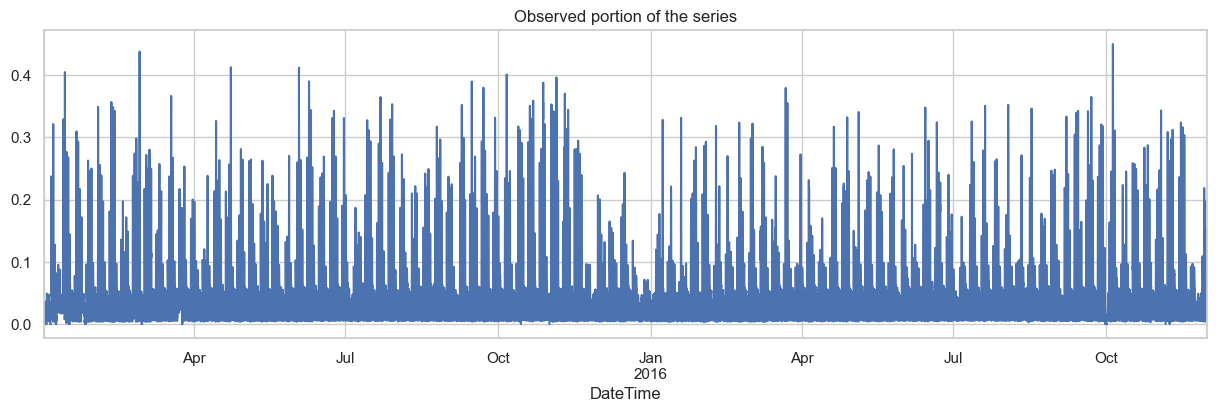

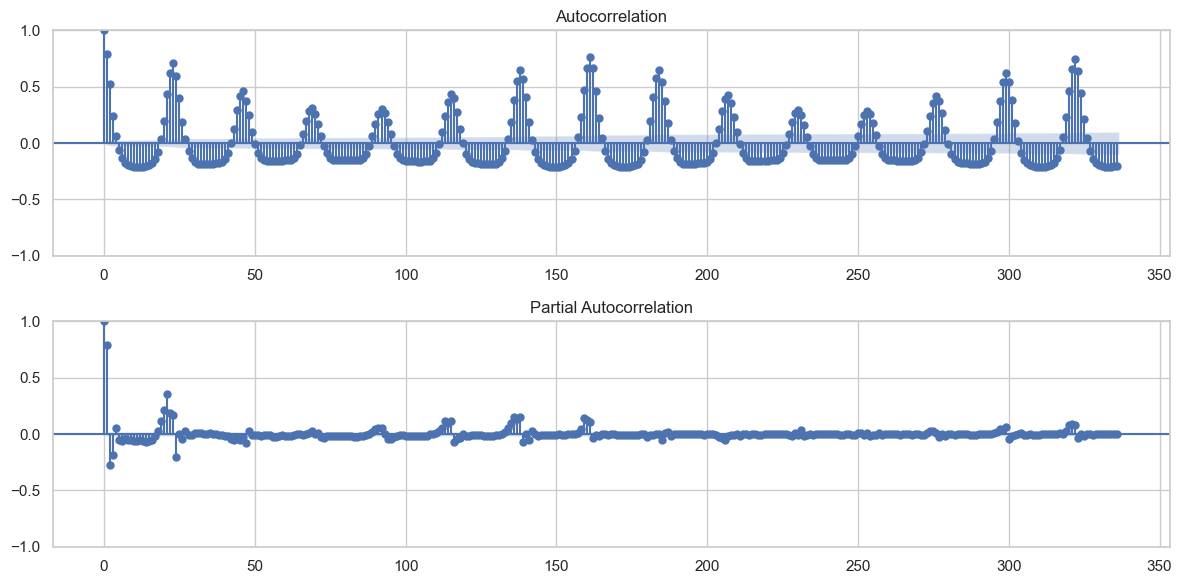

In [25]:
# Cell 4
fig, ax = plt.subplots(figsize=(15, 4))
train["X"].plot(ax=ax)
ax.set(title="Observed portion of the series")
plt.show()

# ACF/PACF up to two weeks (336 lags)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(train["X"].dropna(), lags=336, ax=axes[0])
plot_pacf(train["X"].dropna(), lags=336, ax=axes[1])
plt.tight_layout()


In [26]:
# Cell 5
ucm = UnobservedComponents(
    endog=train["X"],
    level="local linear trend",        # stochastic level & slope – LLT
    seasonal=24,                      # stochastic *daily* seasonality
    freq_seasonal=[                   # stochastic *weekly* seasonality
        {"period": 168, "harmonics": 3}
    ],
    # uncomment next line if residual ACF shows short memory you wish to keep here
    # autoregressive=1,
    # cycle=True, damped_cycle=True,  # enable if a low-freq cycle is visible
)


In [27]:
# Cell 6
results = ucm.fit(disp=False)
print(results.summary())


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                Unobserved Components Results                                 
Dep. Variable:                                      X   No. Observations:                16799
Model:                             local linear trend   Log Likelihood               34054.318
                            + stochastic seasonal(24)   AIC                         -68098.637
                   + stochastic freq_seasonal(168(3))   BIC                         -68060.001
Date:                                Fri, 04 Jul 2025   HQIC                        -68085.888
Time:                                        22:40:50                                         
Sample:                                    01-01-2015                                         
                                         - 11-30-2016                                         
Covariance Type:                                  opg                                         
                                  coef    std err 

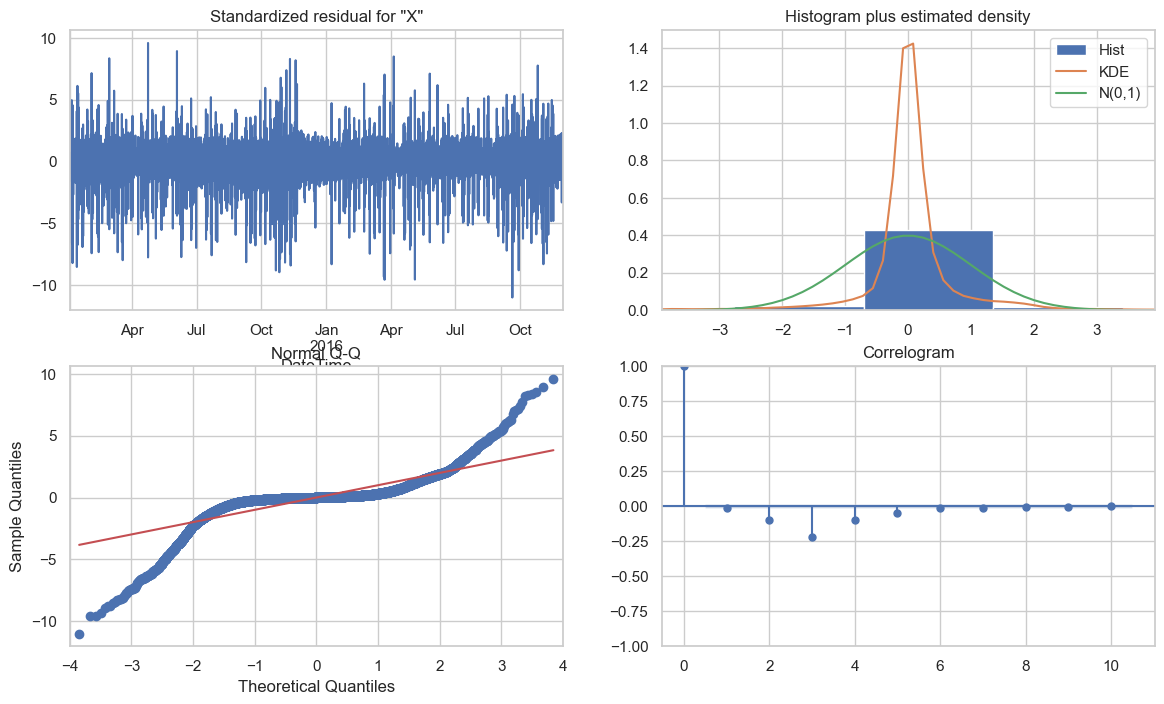

In [28]:
# Cell 7
results.plot_diagnostics(figsize=(14, 8))
plt.show()


In [29]:
# Cell 8
fc = results.get_forecast(steps=n_missing)
fc_mean = fc.predicted_mean
fc_ci   = fc.conf_int(alpha=0.05)      # 95 % interval

# Assemble into a DataFrame
forecast_df = pd.DataFrame({
    "X_hat": fc_mean.values,
    "lower": fc_ci.iloc[:, 0].values,
    "upper": fc_ci.iloc[:, 1].values,
}, index=forecast_index)

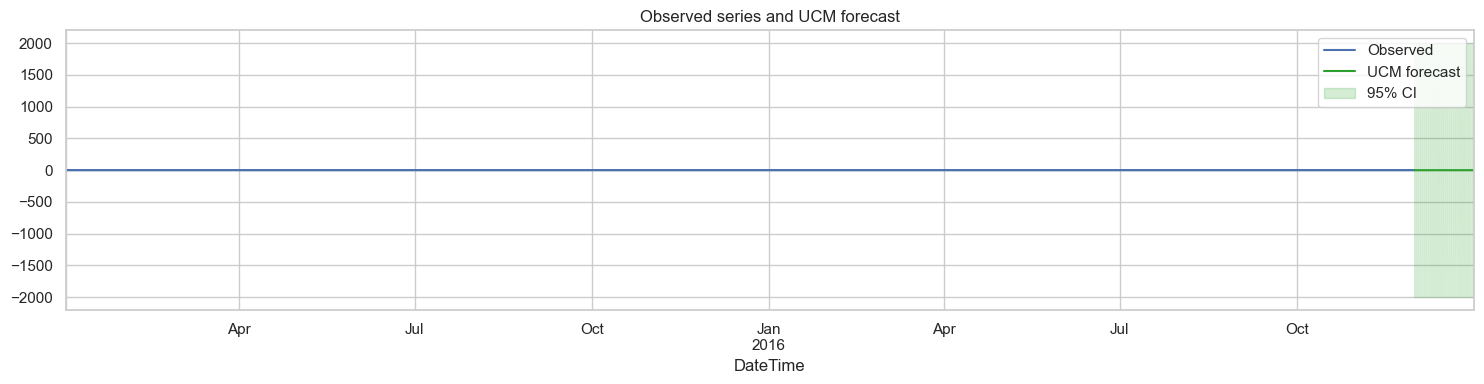

In [30]:
# Cell 9
fig, ax = plt.subplots(figsize=(15, 4))
train["X"].plot(ax=ax, label="Observed")
forecast_df["X_hat"].plot(ax=ax, color="tab:green", label="UCM forecast")
ax.fill_between(forecast_df.index, forecast_df["lower"], forecast_df["upper"],
                color="tab:green", alpha=0.2, label="95% CI")
ax.legend(); ax.set(title="Observed series and UCM forecast")
plt.tight_layout()


In [31]:
# Cell 10
out = (forecast_df
       .rename(columns={"X_hat": "UCM"})
       .assign(ARIMA=np.nan, ML=np.nan)          # placeholders for future models
       .reset_index()
       .rename(columns={"index": "DateTime"}))

out.to_csv("predictions_ucm.csv", index=False)
print("File predictions_ucm.csv written")


File predictions_ucm.csv written


c:\Users\Utente\time series\venv\lib\site-packages\statsmodels\tsa\statespace\structural.py:1738: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


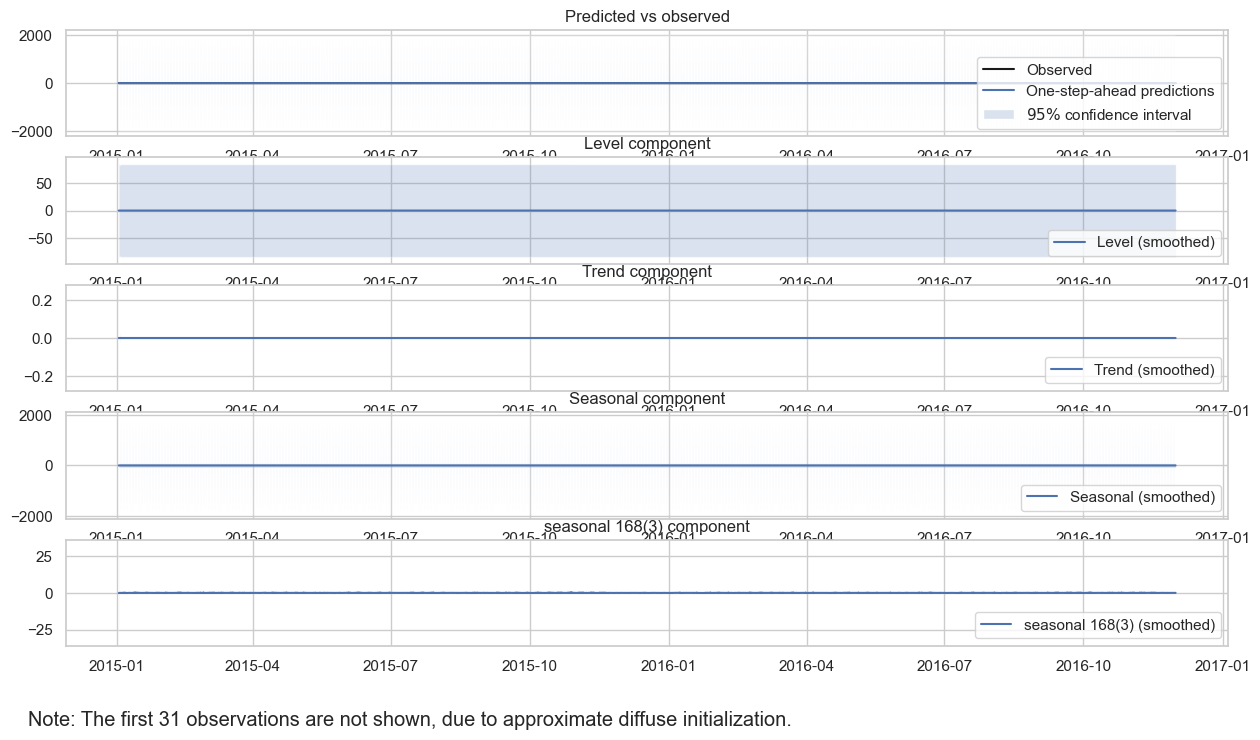

In [32]:
# Cell 11
results.plot_components(legend_loc='lower right', figsize=(15, 8))
plt.show()
